In [1]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore
import pickle
import tables

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [310]:
#data_dir = '/media/bigdata/Abuzar_Data/AM11/AM11_4Tastes_191030_114043_copy/'
data_dir = '/media/bigdata/Abuzar_Data/AM35/AM35_4Tastes_201230_115322/'
plot_super_dir = os.path.join(data_dir,'changepoint_plots')
if not os.path.exists(plot_super_dir):
    os.makedirs(plot_super_dir)
#data_dir = '/media/bigdata/Abuzar_Data/AM39/AM39_4Tastes_210203_123522/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

All tastes have equal dimensions,concatenating and normalizing


In [364]:
median_amplitude = np.median(dat.amplitude_array,axis=(0,2))

In [73]:
fin_spikes = np.array(dat.spikes)
print(fin_spikes.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 31 32]
(4, 30, 33, 7000)
18


In [74]:
nrn = np.arange(np.array(fin_spikes).shape[2])
taste_dat = np.array(fin_spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 33, 7000)


In [191]:
# Convert spikes to counts by binning
time_lims = [1500,4000]
bin_width = 10
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
whole_dat_binned = np.sum(taste_dat.reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)
print(whole_dat_binned.shape)
# print(binned_t_vec)

(4, 30, 33, 250)
(4, 30, 33, 700)


In [353]:
states = 3
fit = 40000
samples = 20000
model_save_dir = os.path.join(data_dir,'saved_models',f'vi_{states}_states')
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_name = f'vi_{states}_states_{fit}fit_{samples}samples_time{time_lims}_bin{bin_width}'
print(model_name)

plot_dir = os.path.join(plot_super_dir,model_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
print(plot_dir)

vi_3_states_40000fit_20000samples_time[1500, 4000]_bin10
/media/bigdata/Abuzar_Data/AM35/AM35_4Tastes_201230_115322/changepoint_plots/vi_3_states_40000fit_20000samples_time[1500, 4000]_bin10


In [321]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
whole_dat_binned_long = np.reshape(whole_dat_binned,(-1,*whole_dat_binned.shape[-2:]))
print(dat_binned_long.shape)

(120, 33, 250)


In [322]:
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
# print(mean_vals)
mean_nrn_vals = np.mean(mean_vals,axis=(0,1))
print(mean_nrn_vals.shape) # Trials x nrns

(3, 4, 30, 33, 83)
(4, 3, 33)
(33,)


In [323]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
249
(120, 33, 250)


In [324]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[  0.  83. 166. 249.]
[0.33333333 0.66666667]


In [325]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
    # Priors for each neuron
    lambda_nrn = pm.Exponential('lambda_nrn',1/mean_nrn_vals, shape = (mean_vals.shape[-1]))
    
    # Priors for each state, derived from each neuron
    lambda_state = pm.Exponential('lambda_state',lambda_nrn, shape = (mean_vals.shape[1:]))
    
    lambda_latent = pm.Exponential('lambda', lambda_state[np.newaxis,:,:], testval = mean_vals, 
                            shape = (mean_vals.shape))

print(lambda_nrn.tag.test_value.shape)
print(lambda_state.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)


(33,)
(3, 33)
(4, 3, 33)


In [326]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 2)


In [327]:
print(array_idx.shape)

(120, 33, 250)


In [330]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    if states > 3:
        weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])
    if states > 4:
        weight_4_stack = tt.nnet.sigmoid(array_idx - tau[:,3][...,np.newaxis,np.newaxis])


(120, 33, 250)
(4, 3, 33)


In [332]:
taste_label = np.repeat([0,1,2,3],30)
with model:
    
    if states == 3:
        # 3 states
        lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                    np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
    elif states == 4:
        # 4 states
        lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
                    np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])

    elif states == 5:
        # 5 states
        lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) +\
                    np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[taste_label][:,3][:,:,np.newaxis])+ \
                    np.multiply(weight_4_stack, lambda_latent[taste_label,4][:,:,np.newaxis])


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [334]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Poisson("obs", lambda_, observed=dat_binned_long)

In [335]:
# pm.model_to_graphviz(model)

In [336]:
model_dump_path = os.path.join(model_save_dir,f'dump_{model_name}.pkl')
if os.path.exists(model_dump_path):
    print('Trace loaded from cache')
    with open(model_dump_path, 'rb') as buff:
        data = pickle.load(buff)
    model = data['model']
    trace = data['trace']
    inference = data['inference']
    approx = data['approx']
else:
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        trace = approx.sample(draws=samples)

    print('Dumping trace to cache')
    with open(model_dump_path, 'wb') as buff:
        pickle.dump({'model' : model,
                    'trace': trace,
                    'inference': inference,
                    'approx' : approx}, buff)

  0%|          | 0/40000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.3282e+05: 100%|██████████| 40000/40000 [40:45<00:00, 16.36it/s]  
Finished [100%]: Average Loss = 2.3282e+05


Dumping trace to cache


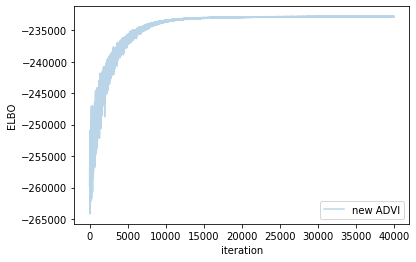

In [339]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
#plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [345]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(20000, 120, 2)
(4, 20000, 3, 33)


In [346]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
sd_lambda = np.std(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

(120, 2)
(4, 33, 3)


(4, 33, 3)
(4, 33, 3)


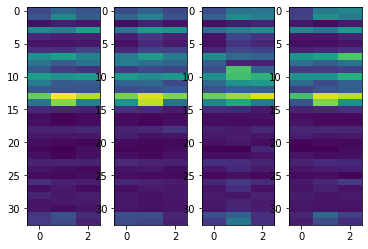

<Figure size 432x288 with 0 Axes>

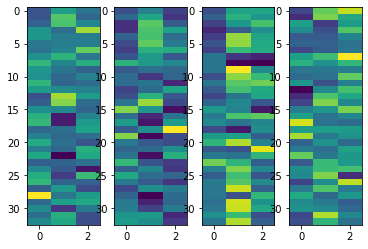

In [347]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')

In [351]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
print(mean_mean_tau.shape)

(2,)


In [354]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
fig,ax = plt.subplots()
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
        
plt.savefig(os.path.join(plot_dir,'cumulated_changepoint_hist'),dpi=300)
plt.close(fig)

(2400000, 2)


In [221]:
plot_spikes = dat_binned_long>0

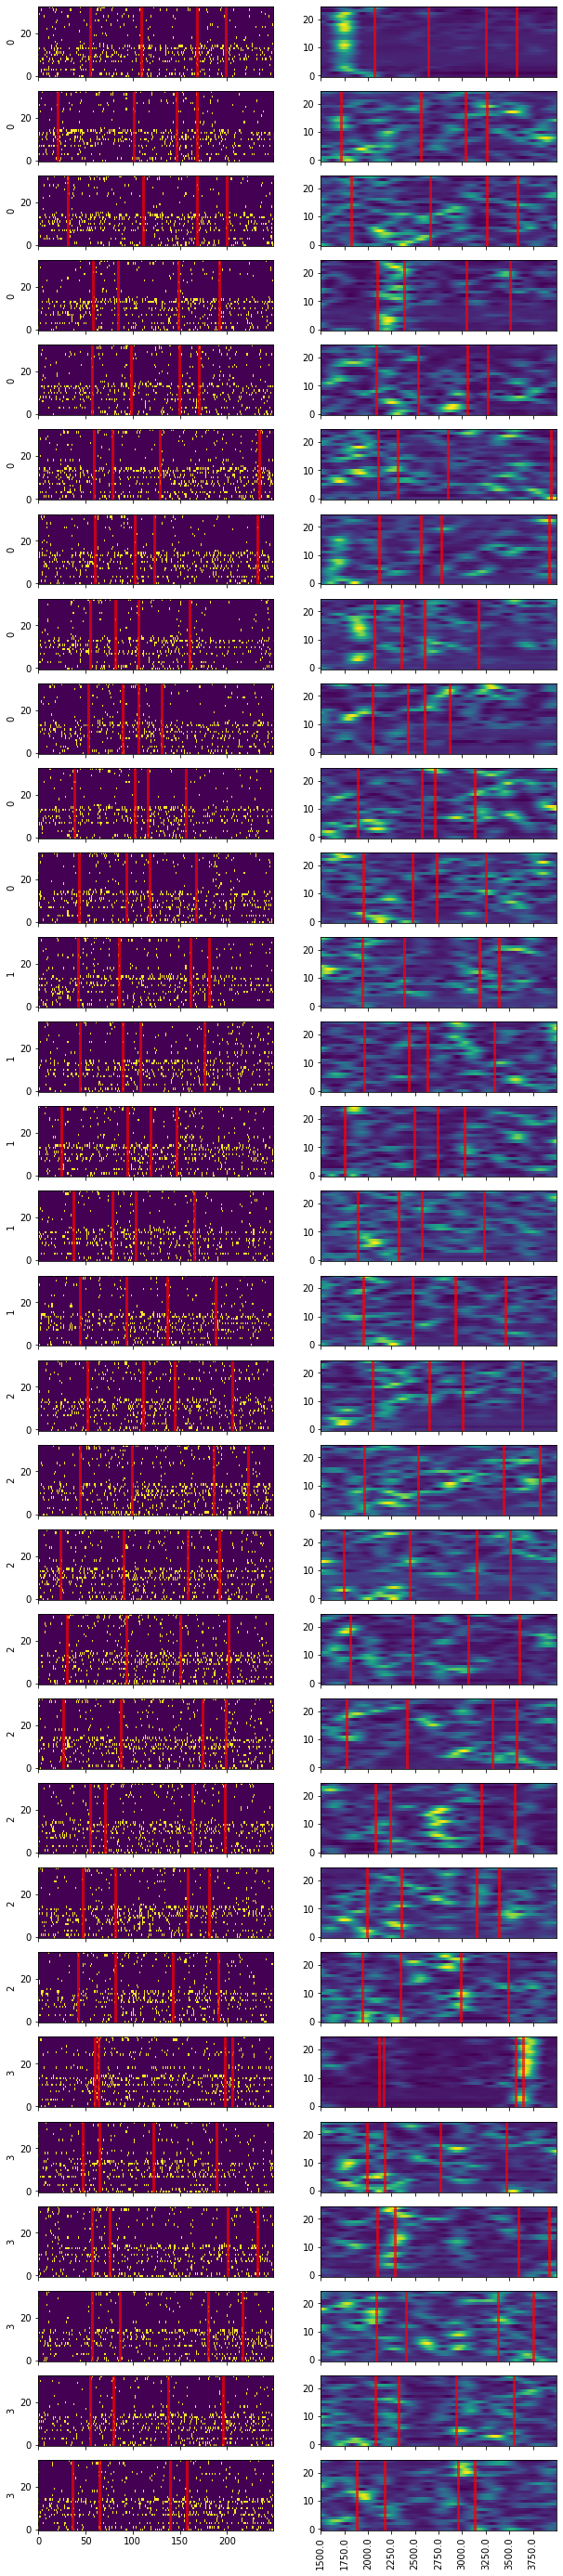

In [225]:
# Overlay raster with CDF of switchpoints
trial_count = 30
tick_interval = 5
trial_inds = np.sort(np.random.choice(np.arange(mean_tau.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count,1,sharex='col', figsize = (10,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
    ax[num,0].set_ylabel(taste_label[trial])
    ax[num,0].vlines(mean_tau[trial],-0.5,mean_lambda.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)



In [366]:
# Overlay raster with CDF of switchpoints
tick_interval = 5

for this_taste in np.sort(np.unique(taste_label)):
    trial_inds = np.where(taste_label==this_taste)[0]

    fig, ax = plt.subplots(len(trial_inds),3,sharex='col', figsize = (15,50))
    for num,trial in enumerate(trial_inds):
        ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
        ax[num,0].set_ylabel(taste_label[trial])
        ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
        ax[num,0].vlines(mean_tau[trial],-0.5,mean_lambda.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
        ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

        ax[num,1].set_xticks(stft_tick_inds)
        ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

        for state in range(tau_samples.shape[-1]):
            ax[num,-1].hist(tau_samples[:,trial,state], bins = 100, density = True)
            
    plt.savefig(os.path.join(plot_dir,'taste{}_changepoints'.format(this_taste)),dpi=300)
    plt.close(fig)


In [356]:
# Find trials where the mean tau for one changepoint is outside the 95% interval for other taus 
print(mean_tau.shape)
print(tau_samples.shape)
# # pre-compute ecdf for each tau for each trial
percentile_array = np.zeros((*mean_tau.shape,mean_tau.shape[-1]))
for trial_num, (this_mean_tau, this_tau_dist) in enumerate(zip(mean_tau, np.moveaxis(tau_samples,0,-1))):
    for tau1_val, this_tau in enumerate(this_mean_tau):
        for tau2_val, this_dist in enumerate(this_tau_dist):
            percentile_array[trial_num, tau1_val, tau2_val] = percentileofscore(this_dist, this_tau)

(120, 2)
(20000, 120, 2)


In [359]:
# Visually, threshold of <1 percentile seems compelling
# Find all trials where all the upper triangular elements are <1
# and lower triangular elements are >99
lower_thresh = 1
upper_thresh = 100 - lower_thresh

good_trial_list = np.where([all(x[np.triu_indices(states-1,1)] < lower_thresh) \
                  and all(x[np.tril_indices(states-1,-1)] > upper_thresh) \
                  for x in percentile_array])[0]
print(len(good_trial_list))
print(good_trial_list)

119
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119]


In [367]:
# Plot only good trials
# Overlay raster with CDF of switchpoints
tick_interval = 5
max_trials = 15
num_plots = int(np.ceil(len(good_trial_list)/max_trials))
trial_inds_list = [good_trial_list[x*max_trials:(x+1)*max_trials] for x in np.arange(num_plots)]

for fig_num in np.arange(num_plots):
    trial_inds = trial_inds_list[fig_num]
    trial_count = len(trial_inds)
    
    fig, ax = plt.subplots(trial_count,3,sharex='col', figsize = (20,trial_count*3))
    for num,trial in enumerate(trial_inds):
        ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
        ax[num,0].set_ylabel(taste_label[trial])
        ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
        ax[num,0].vlines(mean_tau[trial],-0.5,mean_lambda.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
        ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

        ax[num,1].set_xticks(stft_tick_inds)
        ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

        for state in range(tau_samples.shape[-1]):
            ax[num,-1].hist(tau_samples[:,trial,state], bins = 100, density = True)

    plt.savefig(os.path.join(plot_dir,'good_changepoints{}'.format(fig_num)),dpi=300)
    plt.close(fig)


# Spike alignment

In [113]:
# For visualization
# Take firing around each transition and stack it together to make a PSTH (not mean firing)
# Perform alignemnt on uncut data (0-7000 ms) so there are no missing parts
# (in case a changepoint is too close to the start or the end)
# Before and after alignment
window_radius_time = 300 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# To translate the changepoints according to the start of the whole trial
mean_tau_adj = mean_tau + (time_lims[0]//bin_width)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau_adj)

print(dat_binned_long.shape)
print(int_mean_tau.shape)

30
(120, 33, 225)
(120, 3)


In [114]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*whole_dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)

(120, 33, 3, 60)


In [115]:
# Spikes aligned to trial-specific transitions
for trial in range(whole_dat_binned_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < whole_dat_binned_long.shape[-1]) + \
                                            whole_dat_binned_long.shape[-1] * (upper_bound > whole_dat_binned_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = whole_dat_binned_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = whole_dat_binned_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [116]:
# Spikes aligned to average transitions
unaligned_spikes = np.ones((*whole_dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_spikes.shape)
int_unaligned_tau = np.vectorize(np.int)(np.mean(mean_tau_adj,axis=0))
# Spikes aligned to trial-specific transitions
for switch in range(int_unaligned_tau.shape[-1]):

    # Check whether we can pick out a window
    lower_bound = (int_unaligned_tau[switch] - window_radius_bins)
    fin_lower_bound = lower_bound * (lower_bound > 0)
    upper_bound = (int_unaligned_tau[switch] + window_radius_bins)
    fin_upper_bound = upper_bound * (upper_bound < whole_dat_binned_long.shape[-1]) + \
                                        whole_dat_binned_long.shape[-1] * (upper_bound > whole_dat_binned_long.shape[-1])

    # Done this way so all windows can be accomodated whether they are of the expected size or not
    lower_window = whole_dat_binned_long[:,:,fin_lower_bound:int_unaligned_tau[switch]]
    upper_window = whole_dat_binned_long[:,:,int_unaligned_tau[switch]:fin_upper_bound]
    #If window is smaller than the expected size, put it in centered on transition
    unaligned_spikes[:,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
    unaligned_spikes[:,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

(120, 33, 3, 60)


In [117]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(4, 30, 33, 3, 60)


(33, 3, 120, 60)


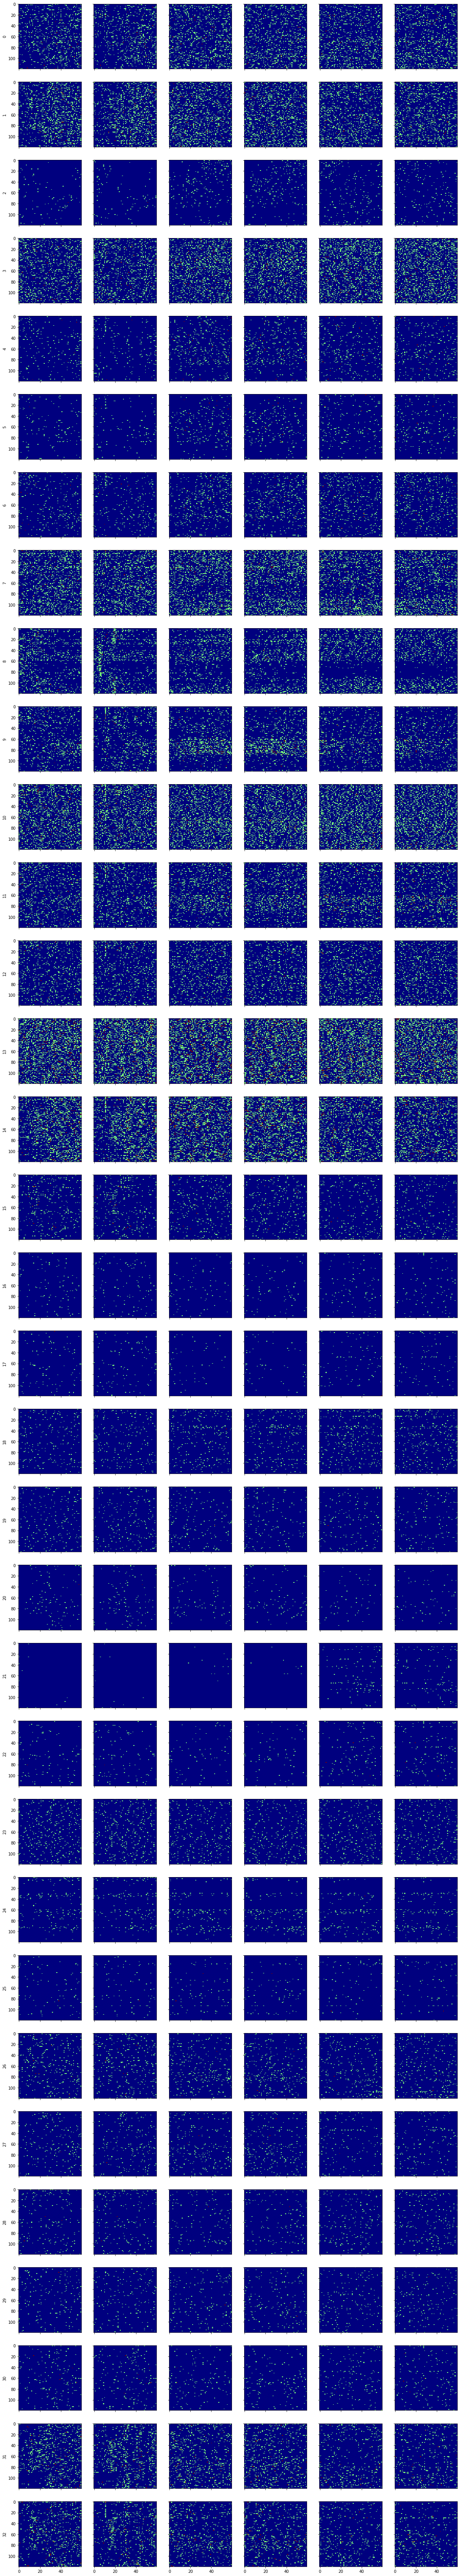

In [118]:
plot_dat_aligned = np.moveaxis(aligned_spikes,0,2)
plot_dat_unaligned = np.moveaxis(unaligned_spikes,0,2)
print(plot_dat_aligned.shape)

fig, ax = plt.subplots(plot_dat_aligned.shape[0],plot_dat_aligned.shape[1]*2,
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(plot_dat_aligned.shape[:2])
for this_iter in iters:
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    ax[this_iter[0],2*this_iter[1]].imshow(plot_dat_aligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=0,vmax=2)
    ax[this_iter[0],(2*this_iter[1])+1].imshow(plot_dat_unaligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=0,vmax=2)
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
    

In [121]:
# Calculate palatability correlations from the aligned spikes
# Can do aligned firing rate next
info_file_path = glob.glob(os.path.join(data_dir,'**.info'))[0]
print(info_file_path)
with open(info_file_path,'r') as file_connect:
    info_dict = json.load(file_connect)
pal_rankings = np.squeeze(info_dict['taste_params']['pal_rankings'])
print(pal_rankings)
print(plot_dat_aligned.shape)

/media/bigdata/Abuzar_Data/AM35/AM35_4Tastes_201230_115322/AM35_4Tastes_201230_115322.info
[3 4 2 1]
(33, 3, 120, 60)


In [122]:
pal_vec = np.repeat(pal_rankings,plot_dat_aligned.shape[2]//len(pal_rankings))
aligned_dat_for_corr = np.moveaxis(plot_dat_aligned,-2,-1)
print(aligned_dat_for_corr.shape)
aligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
aligned_spearman = np.zeros(aligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    aligned_spearman[this_ind] = spearmanr(aligned_dat_for_corr[this_ind], pal_vec)[0]

print(aligned_spearman.shape)

(33, 3, 60, 120)
(33, 3, 60)


# Firing Rate Alignment

In [127]:
taste_dat.shape[-1]//dat.all_normalized_firing.shape[-1]

25

In [128]:
# For visualization
# Take firing around each transition and stack it together
# Perform alignemnt on uncut data (0-7000 ms) so there are no missing parts
# (in case a changepoint is too close to the start or the end)
# Before and after alignment
window_radius_time = 1000 # ms
# firing_bin_width = (dat.firing_rate_params['baks_resolution'] * 1000)
firing_bin_width = (taste_dat.shape[-1] // dat.all_normalized_firing.shape[-1])
print(firing_bin_width)
window_radius_bins = int(window_radius_time//firing_bin_width)
print(window_radius_bins)

# To translate the changepoints according to the start of the whole trial
# and convert them to firing_rate bins
mean_tau_adj = ((mean_tau + (time_lims[0]//bin_width))*bin_width)/firing_bin_width

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau_adj)

firing_long = dat.all_normalized_firing.swapaxes(0,1)
print(firing_long.shape)
print(int_mean_tau.shape)

25
40
(120, 33, 271)
(120, 3)


In [129]:
# Make time vector for plots
t_align = np.arange(-window_radius_time,window_radius_time,firing_bin_width)

In [130]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
# Initiated with -1 to make sure gaps are visible
aligned_firing = np.ones((*firing_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_firing.shape)

(120, 33, 3, 80)


In [131]:
# Spikes aligned to trial-specific transitions
for trial in range(firing_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < firing_long.shape[-1]) + \
                                            firing_long.shape[-1] * (upper_bound > firing_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = firing_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = firing_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_firing[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_firing[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [132]:
# Spikes aligned to average transitions
unaligned_firing = np.ones((*firing_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_firing.shape)
int_unaligned_tau = np.vectorize(np.int)(np.mean(mean_tau_adj,axis=0))
# Spikes aligned to trial-specific transitions
for switch in range(int_unaligned_tau.shape[-1]):

    # Check whether we can pick out a window
    lower_bound = (int_unaligned_tau[switch] - window_radius_bins)
    fin_lower_bound = lower_bound * (lower_bound > 0)
    upper_bound = (int_unaligned_tau[switch] + window_radius_bins)
    fin_upper_bound = upper_bound * (upper_bound < firing_long.shape[-1]) + \
                                        firing_long.shape[-1] * (upper_bound > firing_long.shape[-1])

    # Done this way so all windows can be accomodated whether they are of the expected size or not
    lower_window = firing_long[:,:,fin_lower_bound:int_unaligned_tau[switch]]
    upper_window = firing_long[:,:,int_unaligned_tau[switch]:fin_upper_bound]
    #If window is smaller than the expected size, put it in centered on transition
    unaligned_firing[:,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
    unaligned_firing[:,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

(120, 33, 3, 80)


In [133]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(4, 30, 33, 3, 60)


(33, 3, 120, 80)


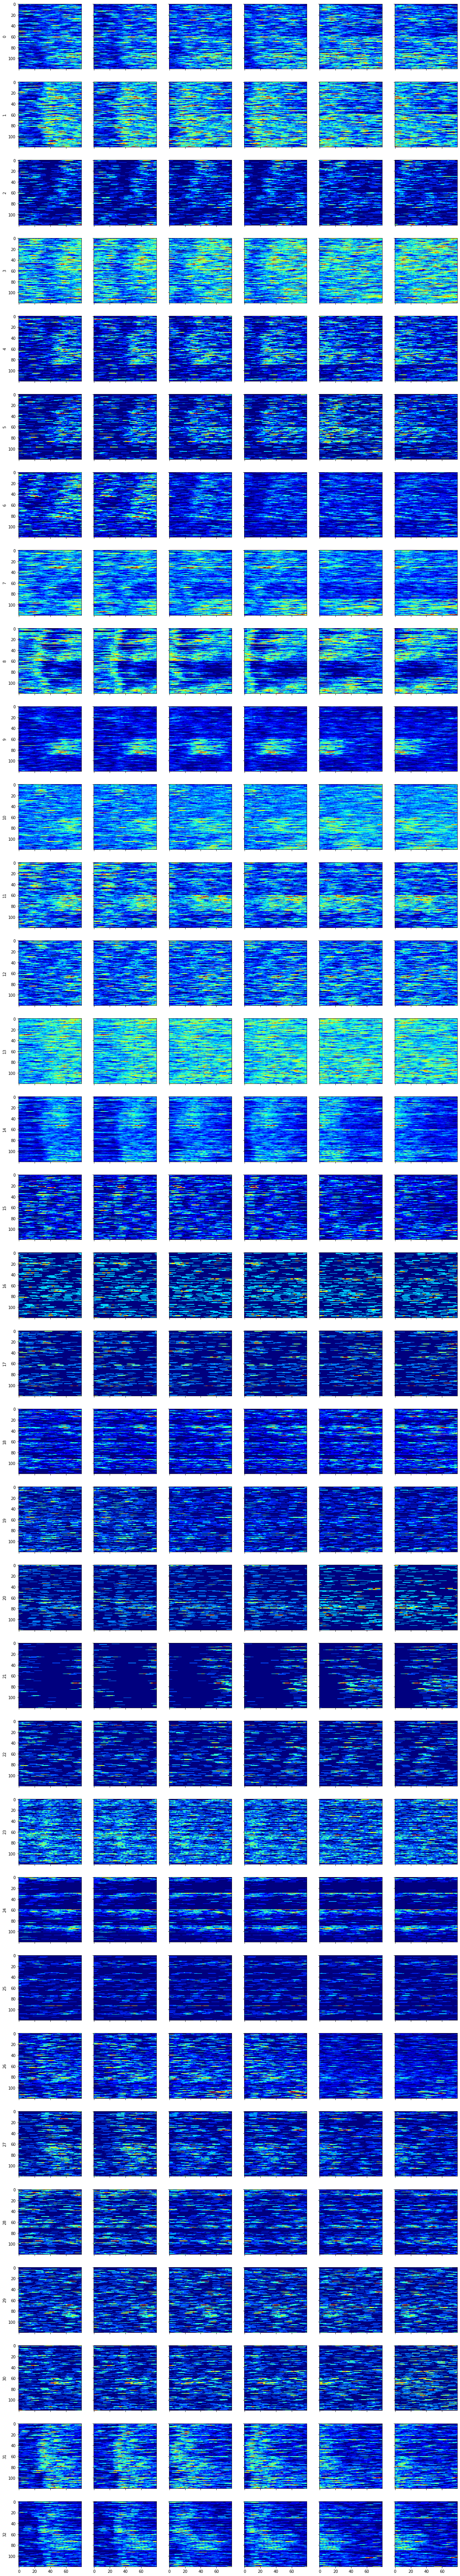

In [134]:
plot_dat_aligned = np.moveaxis(aligned_firing,0,2)
plot_dat_unaligned = np.moveaxis(unaligned_firing,0,2)
print(plot_dat_aligned.shape)

fig, ax = plt.subplots(plot_dat_aligned.shape[0],plot_dat_aligned.shape[1]*2,
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(plot_dat_aligned.shape[:2])
for this_iter in iters:
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    ax[this_iter[0],2*this_iter[1]].imshow(plot_dat_aligned[this_iter],aspect='auto',cmap='jet')
    ax[this_iter[0],(2*this_iter[1])+1].imshow(plot_dat_unaligned[this_iter],aspect='auto',cmap='jet')
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
    

In [141]:
pal_vec = np.repeat(pal_rankings,plot_dat_aligned.shape[2]//len(pal_rankings))
aligned_dat_for_corr = np.moveaxis(plot_dat_aligned,-2,-1)
print(aligned_dat_for_corr.shape)
aligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
aligned_spearman = np.zeros(aligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    aligned_spearman[this_ind] = spearmanr(aligned_dat_for_corr[this_ind], pal_vec)[0]

print(aligned_spearman.shape)
# mean_aligned_spearman_r = np.abs(np.nanmean(aligned_spearman,axis=0))
mean_aligned_spearman_r = np.nanmean(np.abs(aligned_spearman),axis=0)


(33, 3, 80, 120)
(33, 3, 80)


In [142]:
unaligned_dat_for_corr = np.moveaxis(plot_dat_unaligned,-2,-1)
unaligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
unaligned_spearman = np.zeros(unaligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    unaligned_spearman[this_ind] = spearmanr(unaligned_dat_for_corr[this_ind], pal_vec)[0]

print(unaligned_spearman.shape)
# mean_unaligned_spearman_r = np.abs(np.nanmean(unaligned_spearman,axis=0))
mean_unaligned_spearman_r = np.nanmean(np.abs(unaligned_spearman),axis=0)

(33, 3, 80)


In [143]:
print(mean_aligned_spearman_r.shape)

(3, 80)


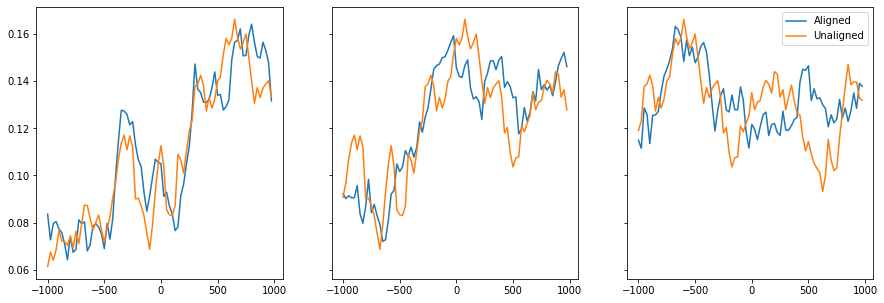

In [144]:
fig, ax = plt.subplots(1,states-1, figsize=(15,5), sharey = True)
for change in range(states-1):
    ax[change].plot(t_align, mean_aligned_spearman_r[change],label = 'Aligned')
    ax[change].plot(t_align, mean_unaligned_spearman_r[change], label = 'Unaligned')
plt.legend()

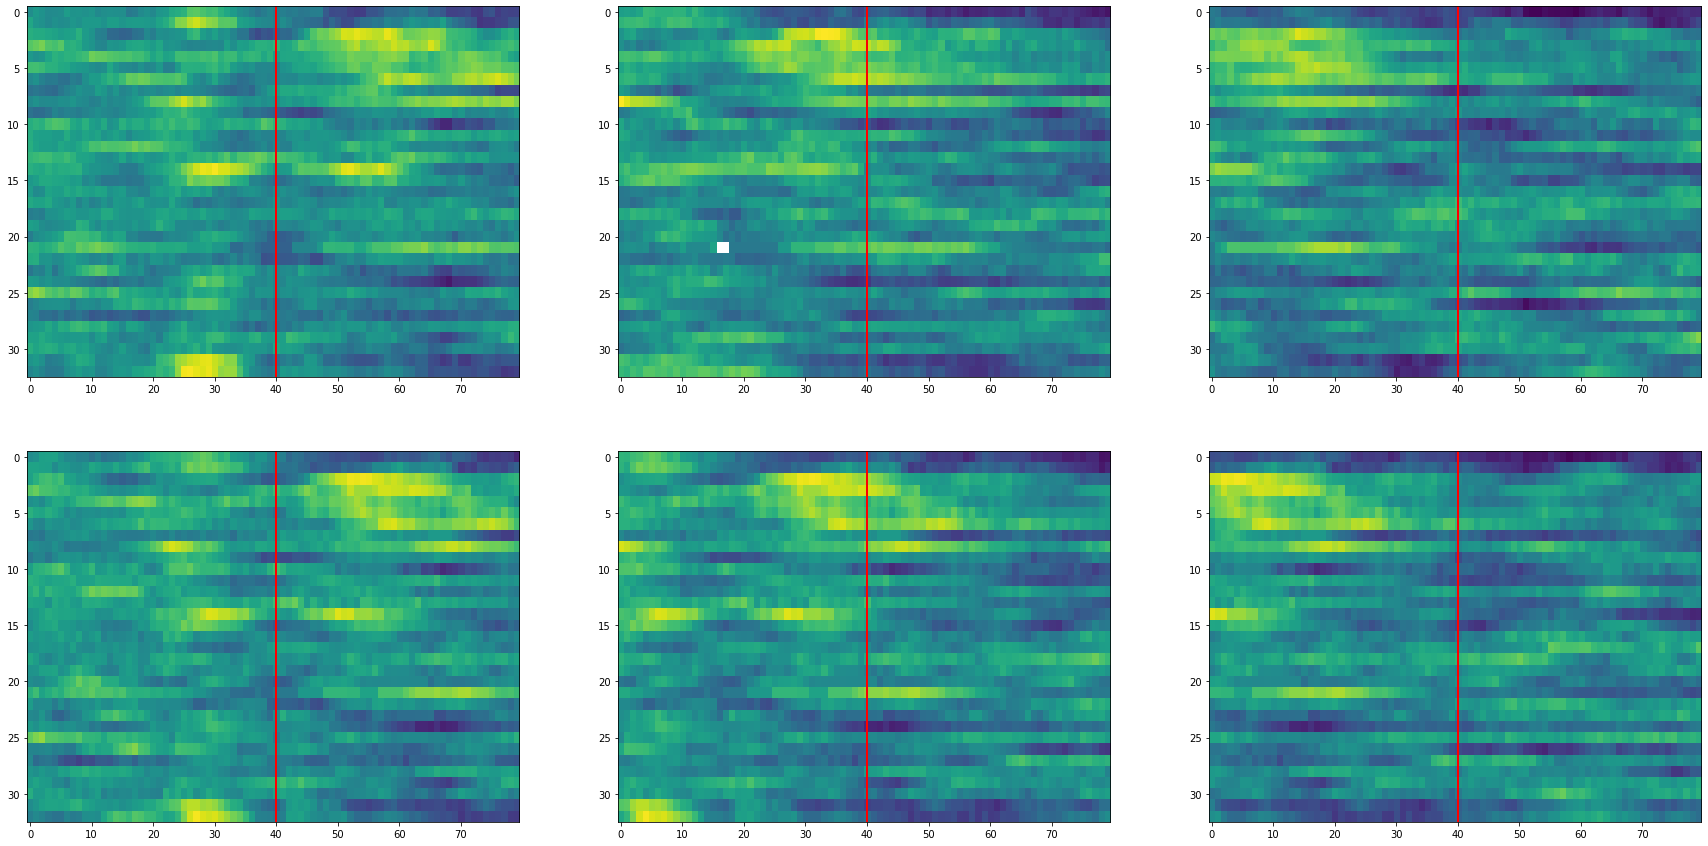

In [145]:
all_corrs = np.concatenate((aligned_spearman,unaligned_spearman))
min_val,max_val = np.nanmin(all_corrs,axis=None),np.nanmax(all_corrs,axis=None)
fig, ax = plt.subplots(2,states-1,figsize = (30,15))
for num,state in enumerate(aligned_spearman.swapaxes(0,1)):
    ax[0,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[0,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
for num,state in enumerate(unaligned_spearman.swapaxes(0,1)):
    ax[1,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[1,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)

In [147]:
# # Is the difference improved by "good" trials
# good_pal_vec = pal_vec[good_trial_list]
# good_aligned_dat_for_corr = aligned_dat_for_corr[...,good_trial_list]
# print(good_aligned_dat_for_corr.shape)
# good_aligned_inds = list(np.ndindex(good_aligned_dat_for_corr.shape[:-1]))
# good_aligned_spearman = np.zeros(good_aligned_dat_for_corr.shape[:-1])
# for this_ind in good_aligned_inds:
#     good_aligned_spearman[this_ind] = spearmanr(good_aligned_dat_for_corr[this_ind], good_pal_vec)[0]

# print(good_aligned_spearman.shape)
# # good_mean_aligned_spearman_r = np.abs(np.nanmean(good_aligned_spearman,axis=0))
# good_mean_aligned_spearman_r = np.nanmean(np.abs(good_aligned_spearman),axis=0)

In [148]:
# good_unaligned_dat_for_corr = unaligned_dat_for_corr[...,good_trial_list]
# print(good_unaligned_dat_for_corr.shape)
# good_unaligned_inds = list(np.ndindex(good_unaligned_dat_for_corr.shape[:-1]))
# good_unaligned_spearman = np.zeros(good_unaligned_dat_for_corr.shape[:-1])
# for this_ind in good_unaligned_inds:
#     good_unaligned_spearman[this_ind] = spearmanr(good_unaligned_dat_for_corr[this_ind], good_pal_vec)[0]

# print(good_unaligned_spearman.shape)
# # good_mean_unaligned_spearman_r = np.abs(np.nanmean(good_unaligned_spearman,axis=0))
# good_mean_unaligned_spearman_r = np.nanmean(np.abs(good_unaligned_spearman),axis=0)

In [149]:
# fig, ax = plt.subplots(1,states-1, figsize=(15,5),sharey=True)
# for change in range(states-1):
#     ax[change].plot(t_align, good_mean_aligned_spearman_r[change],label = 'Aligned')
#     ax[change].plot(t_align, good_mean_unaligned_spearman_r[change], label = 'Unaligned')
# plt.legend()

In [150]:
# all_corrs = np.concatenate((good_aligned_spearman,good_unaligned_spearman))
# min_val,max_val = np.nanmin(all_corrs,axis=None),np.nanmax(all_corrs,axis=None)
# fig, ax = plt.subplots(2,states-1,figsize = (30,15))
# for num,state in enumerate(good_aligned_spearman.swapaxes(0,1)):
#     ax[0,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
#     ax[0,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
# for num,state in enumerate(good_unaligned_spearman.swapaxes(0,1)):
#     im = ax[1,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
#     ax[1,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
# plt.colorbar(im)

In [151]:
# Calculate correlation of average firing rate in each state to palatability
# There should be a single DOMINANT palatability state
print(int_mean_tau.shape)
time_lim_inds = np.array(time_lims)//firing_bin_width
print(time_lim_inds)
bounding_mean_tau = np.hstack((np.repeat(time_lim_inds[0],int_mean_tau.shape[0])[:,np.newaxis],
                              int_mean_tau,
                              np.repeat(time_lim_inds[1],int_mean_tau.shape[0])[:,np.newaxis]))
# print(bounding_mean_tau)

(120, 3)
[ 70 160]


In [152]:
print(firing_long.shape)
mean_state_firing = np.zeros((states,*firing_long.shape[:-1]))
print(mean_state_firing.shape)
inds = list(np.ndindex(mean_state_firing.shape[:-1]))
for this_ind in inds:
    temp_firing = firing_long[this_ind[1:]]
    temp_inds = bounding_mean_tau[this_ind[1],this_ind[0]:(this_ind[0]+2)]
    mean_state_firing[this_ind] = np.mean(temp_firing[:,temp_inds[0]:temp_inds[1]],axis=-1)

(120, 33, 271)
(4, 120, 33)


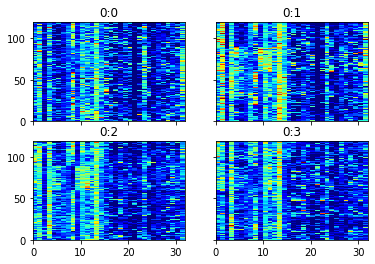

In [153]:
# visualize.firing_overview(stats.zscore(mean_state_firing,axis=1));
visualize.firing_overview(mean_state_firing);

In [154]:
# For each state, correlate the acticity of all the neurons to palatability
# And compare with mean firing of non-aligned windows of time
mean_firing_for_corr = np.swapaxes(mean_state_firing,-2,-1)
mean_firing_corrs = np.zeros(mean_firing_for_corr.shape[:-1])
print(mean_firing_for_corr.shape)
ndinds = list(np.ndindex(mean_firing_for_corr.shape[:-1]))
for this_ind in ndinds:
     mean_firing_corrs[this_ind] = \
        spearmanr(mean_firing_for_corr[this_ind], pal_vec)[0]
print(mean_firing_corrs.shape)

(4, 33, 120)
(4, 33)


[0.09699686 0.14865878 0.16821337 0.15032215]


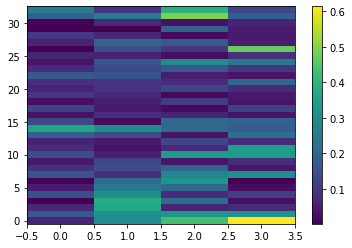

In [155]:
im = visualize.imshow(np.abs(mean_firing_corrs.T))
print(np.mean(np.abs(mean_firing_corrs),axis=1))
plt.colorbar(im);

In [ ]:
# Calculate palatability correlation with aligned and unaligned PCs